Плужникова Анастасия Дмитриевна, s4101

In [1]:
! pip install python-graphblas[default]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 7.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread
import timeit
import random

# Реализация функций и проверка корректности (п 1-4)

In [37]:
def SSSP(A, source):
    n = A.nrows
    w = Vector(A.dtype, A.nrows)
    w[source] << 0
    for k in range (n-2):
        w_old = w.dup()
        w(binary.min) << w.vxm(A, semiring.min_plus)
        if w.isequal(w_old):
            break
    # Вывод
    res = []
    for i in range(n):
        res.append(w[i].value)
    return [ float('inf') if r is None else r for r in res]

In [41]:
def MSSP(A, sources):
      n = A.nrows
      v = gb.Matrix(A.dtype, len(sources), n)
      for i, source in enumerate(sources):
        v[ i, source] << 0
      w = v.dup()
      for k in range (n-2):
          w_old = w.dup()
          w(binary.min) << w.mxm(A, semiring.min_plus)
          if w.isequal(w_old):
              break
      # Вывод
      res = []
      for j in range(len(sources)):
        res_r = []
        for i in range(n):
            res_r.append(w[j,i].value)
        res_r = [float('inf') if r is None else r for r in res_r]
        res.append([sources[j], res_r])
      return res

In [45]:
def APSP(A):
    n = A.nrows
    D = A.dup()
    for i in range(n):
        D[i, i] << 0

    for k in range(n):
        for i in range(n):
            for j in range(n):
              D_old = D.dup()
              D(binary.min) << D.mxm(A, semiring.min_plus)
              if D.isequal(D_old):
                break
    # Вывод
    res = []
    for j in range(n):
        res_r = []
        for i in range(n):
            res_r.append(D[j,i].value)
        res_r = [float('inf') if r is None else r for r in res_r]
        res.append([j, res_r])
    return res

In [47]:
def APSP_trans(A):
  n = A.nrows
  D = A.dup()
  I = Matrix(bool, n, n)
  for i in range(n):
      I[i, i] = False
  for k in range (n):
      D_old = D.dup()
      D << D.mxm(A, semiring.min_plus).ewise_add(I, op='min')
      if D.isequal(D_old):
          break

  # Вывод
      res = []
  for j in range(n):
        res_r = []
        for i in range(n):
            res_r.append(D[j,i].value)
        res_r = [float('inf') if r is None else r for r in res_r]
        res.append([j, res_r])
  return res

Проверим корректность на трёх матрицах

In [7]:
data = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
    [3, 2, 3, 1, 5, 3, 7, 8, 3, 1, 7, 4],
]
rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)
m

"M_0"      nvals  nrows  ncols  dtype   format
gb.Matrix     12      7      7  INT64  bitmapr
----------------------------------------------
   0  1  2  3  4  5  6
0     2     3         
1              8     4
2                 1   
3  3     3            
4                 7   
5        1            
6        5  7  3

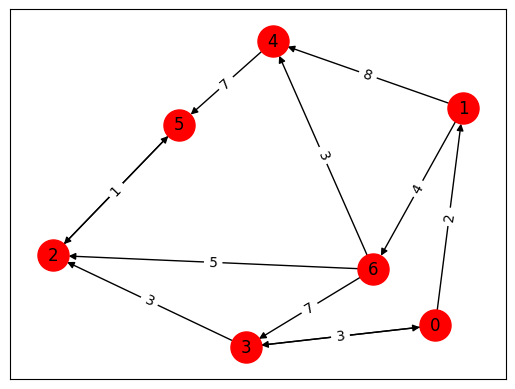

In [8]:
gb.viz.draw(m)

In [40]:
print(SSSP(m, 1))

[14, 0, 9, 11, 7, 10, 4]


In [44]:
print(*MSSP(m, [1, 2]), sep = "\n")

[1, [14, 0, 9, 11, 7, 10, 4]]
[2, [inf, inf, 0, inf, inf, 1, inf]]


In [49]:
print(*APSP(m), sep = "\n")

[0, [0, 2, 6, 3, 9, 7, 6]]
[1, [14, 0, 9, 11, 7, 10, 4]]
[2, [inf, inf, 0, inf, inf, 1, inf]]
[3, [3, 5, 3, 0, 12, 4, 9]]
[4, [inf, inf, 8, inf, 0, 7, inf]]
[5, [inf, inf, 1, inf, inf, 0, inf]]
[6, [10, 12, 5, 7, 3, 6, 0]]


In [50]:
print(*APSP_trans(m), sep = "\n")

[0, [0, 2, 6, 3, 9, 7, 6]]
[1, [14, 0, 9, 11, 7, 10, 4]]
[2, [inf, inf, 0, inf, inf, 1, inf]]
[3, [3, 5, 3, 0, 12, 4, 9]]
[4, [inf, inf, 8, inf, 0, 7, inf]]
[5, [inf, inf, 1, inf, inf, 0, inf]]
[6, [10, 12, 5, 7, 3, 6, 0]]


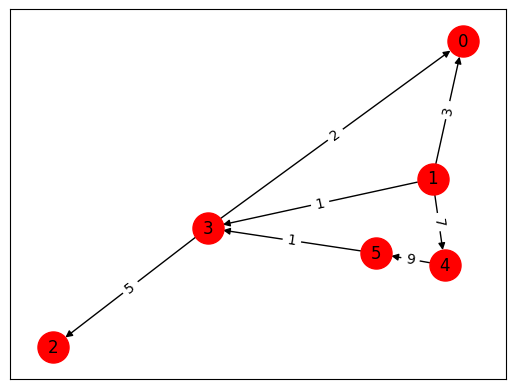

In [51]:
adjacency_matrix = np.array([
    [0, 0, 0, 0, 0, 0],
    [3, 0, 0, 1, 7, 0],
    [0, 0, 0, 0, 0, 0],
    [2, 0, 5, 0, 0, 0],
    [0, 0, 0, 0, 0, 9],
    [0, 0, 0, 1, 0, 0]

])

graph = gb.Matrix.from_dense(adjacency_matrix,missing_value=0)
gb.viz.draw(graph)

In [52]:
print(SSSP(graph, 1))

[3, 0, 6, 1, 7, 16]


In [54]:
print(*MSSP(graph, [0, 1]), sep = "\n")

[0, [0, inf, inf, inf, inf, inf]]
[1, [3, 0, 6, 1, 7, 16]]


In [55]:
print(*APSP(graph), sep = "\n")

[0, [0, inf, inf, inf, inf, inf]]
[1, [3, 0, 6, 1, 7, 16]]
[2, [inf, inf, 0, inf, inf, inf]]
[3, [2, inf, 5, 0, inf, inf]]
[4, [12, inf, 15, 10, 0, 9]]
[5, [3, inf, 6, 1, inf, 0]]


In [56]:
print(*APSP_trans(graph), sep ='\n')

[0, [0, inf, inf, inf, inf, inf]]
[1, [3, 0, 6, 1, 7, 16]]
[2, [inf, inf, 0, inf, inf, inf]]
[3, [2, inf, 5, 0, inf, inf]]
[4, [12, inf, 15, 10, 0, 9]]
[5, [3, inf, 6, 1, inf, 0]]


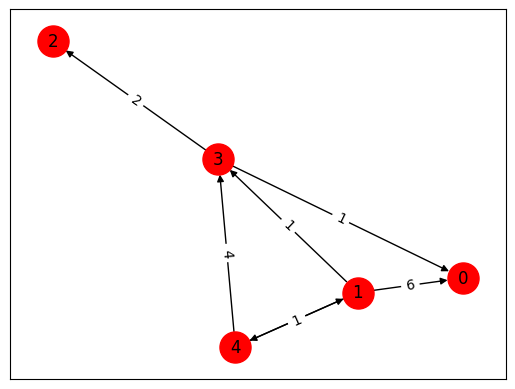

In [57]:
adjacency_matrix2 = np.array([
    [0, 0, 0, 0, 0],
    [6, 0, 0, 1, 3],
    [0, 0, 0, 0, 0],
    [1, 0, 2, 0, 0],
    [0, 1, 0, 4, 0]

])

graph2 = gb.Matrix.from_dense(adjacency_matrix2,missing_value=0)
gb.viz.draw(graph2)

In [58]:
print(SSSP(graph2, 1))

[2, 0, 3, 1, 3]


In [59]:
print(*MSSP(graph2, [0, 1]), sep ='\n')

[0, [0, inf, inf, inf, inf]]
[1, [2, 0, 3, 1, 3]]


In [60]:
print(*APSP(graph2), sep ='\n')

[0, [0, inf, inf, inf, inf]]
[1, [2, 0, 3, 1, 3]]
[2, [inf, inf, 0, inf, inf]]
[3, [1, inf, 2, 0, inf]]
[4, [3, 1, 4, 2, 0]]


In [61]:
print(*APSP_trans(graph2), sep ='\n')

[0, [0, inf, inf, inf, inf]]
[1, [2, 0, 3, 1, 3]]
[2, [inf, inf, 0, inf, inf]]
[3, [1, inf, 2, 0, inf]]
[4, [3, 1, 4, 2, 0]]
